# DeepInsight SqueezeNet Example

This example shows a case of using the output of 
pyDeepInsight.ImageTransformer to train a SqueezeNet model
using PyTorch.

## DeepInsight

In [1]:
from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [2]:
random_state=1515

Load example TCGA data and split into training and testing sets

In [3]:
expr_file = r"./data/curatedTCGAData_RNASeq2GeneNorm-20160128.txt.gz"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['cancer'].values
X = expr.iloc[:, 2:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y)

Normalize data using LogScaler and encode classes

In [4]:
ln = LogScaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

In [5]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

Create t-SNE object

In [6]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    square_distances=True,
    n_jobs=-1
)

Initialize image transformer.

In [7]:
pixel_size = (227,227)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

Train image transformer on training data and transform training 
and testing sets. Values should be between 0 and 1.

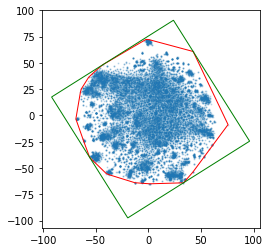

In [8]:
it.fit(X_train, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

The feature density matrix can be extracted from the trained transformer in order to view overall feature overlap.

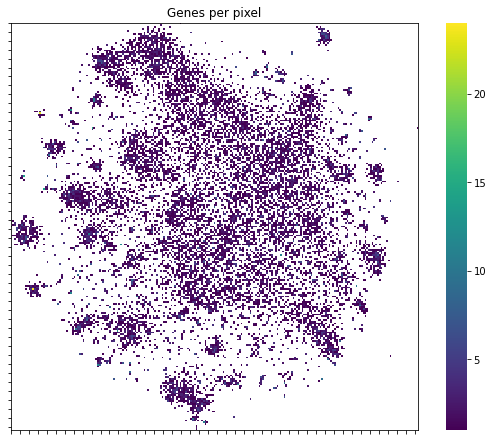

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel")

X_train_imgThe following are showing plots for the image matrices first four samples 
of the training set. 

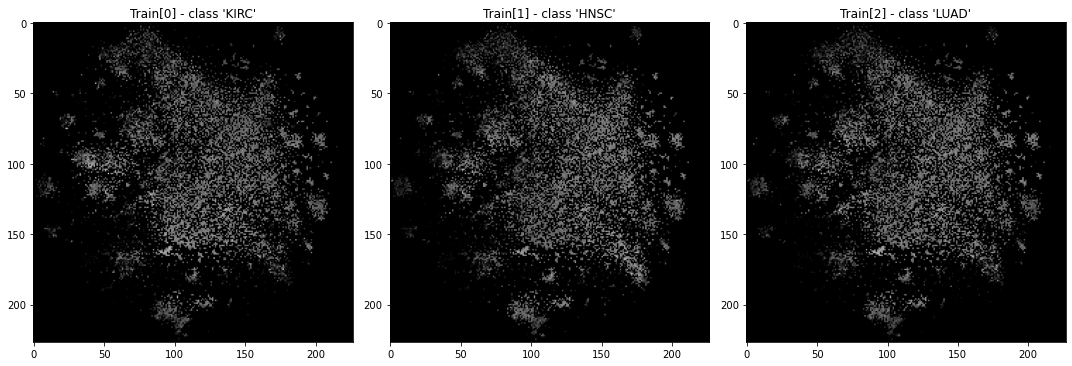

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

Transforming the testing data is done the same as transforming the 
training data.

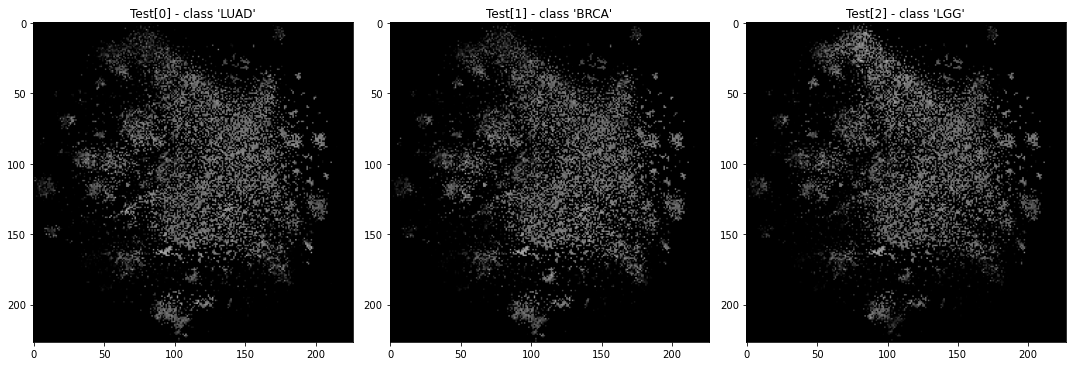

In [11]:
X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text(f"Test[{i}] - class '{y_test[i]}'")
plt.tight_layout()

## SqueezeNet

In [12]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score

import warnings; 
warnings.simplefilter('ignore')

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Download [PyTrorch SqueezeNet 1.1][1] and modify output layer as 
to match number of labels as described in [Finetuning Torchvision Model][2].

[1]: https://pytorch.org/hub/pytorch_vision_squeezenet/
[2]: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [14]:
net = torch.hub.load(
    'pytorch/vision:v0.10.0', 'squeezenet1_1', 
    pretrained=True, verbose=False)
net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), 
                              stride=(1,1))
net = net.to(device)

Transform numpy image format to PyTorch tensor. Using an untrained network,
so normalization as specificed in SqueezeNet documentation is not 
required.


In [15]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [16]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(le.fit_transform(y_train)).to(device)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(le.transform(y_test)).to(device)

Generate pyTorch datasets and dataloaders for training and testing sets.

In [17]:
batch_size = 200

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Specify loss function and optimization algorithm

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=1e-04,
    momentum=0.8,
    weight_decay=1e-05
)

Train SqueezeNet for 200 epochs

In [19]:
for epoch in range(200):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')

[0] loss: 2.263
[20] loss: 1.658
[40] loss: 0.547
[60] loss: 0.284
[80] loss: 0.188
[100] loss: 0.133
[120] loss: 0.115
[140] loss: 0.124
[160] loss: 0.095
[180] loss: 0.122
[199] loss: 0.079


Calculate accuracy of prediction

In [20]:
train_predicted = np.empty(0)
train_true = np.empty(0)
with torch.no_grad():
    net.eval()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        train_predicted = np.append(train_predicted, pred)
        train_true = np.append(train_true, labels.cpu().detach().numpy())

In [21]:
test_predicted = np.empty(0)
test_true = np.empty(0)
with torch.no_grad():
    net.eval()
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())


In [22]:
print(f"The train accuracy was {accuracy_score(train_predicted, train_true):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")

The train accuracy was 0.974
The test accuracy was 0.965


Save model for other examples

In [23]:
torch.save(net.state_dict(), './data/pytorch_squeezenet.pt')